   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Upload traffic video


Saving 5330914-hd_1920_1080_30fps.mp4 to 5330914-hd_1920_1080_30fps.mp4


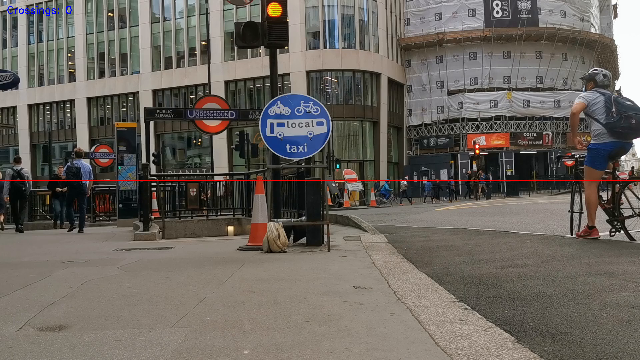

Processing frame: 0
Processing frame: 100
Processing frame: 200


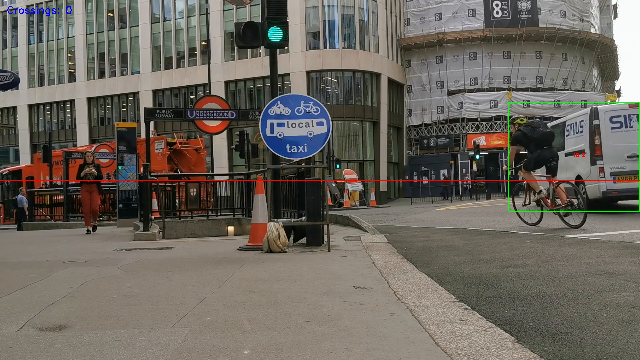

Processing frame: 300
Vehicle 6 crossed line!
Processing frame: 400
Processing frame: 500

✅ Processing complete!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# ================================
# Install libraries
# ================================
!pip -q install ultralytics opencv-python-headless

# ================================
# Imports
# ================================
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab import files
from google.colab.patches import cv2_imshow

# ================================
# Upload video
# ================================
print("Upload traffic video")
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# Load model
# ================================
model = YOLO("yolov8n.pt")

# ================================
# Video setup
# ================================
cap = cv2.VideoCapture(video_path)

width = int(cap.get(3))
height = int(cap.get(4))
fps = max(1, int(cap.get(cv2.CAP_PROP_FPS)))

out = cv2.VideoWriter(
    "output.mp4",
    cv2.VideoWriter_fourcc(*'mp4v'),
    fps,
    (width, height)
)

# ================================
# Virtual red line + tracking
# ================================
line_y = height // 2

object_tracks = {}
next_id = 0

def get_centroid(box):
    x1,y1,x2,y2 = box
    return int((x1+x2)/2), int((y1+y2)/2)

def match_object(centroid):
    global next_id
    for obj_id, prev in object_tracks.items():
        dist = np.linalg.norm(np.array(centroid)-np.array(prev))
        if dist < 50:
            return obj_id
    object_tracks[next_id] = centroid
    next_id += 1
    return next_id-1

# ================================
# Preview control (IMPORTANT)
# ================================
MAX_PREVIEWS = 5
preview_interval = 300
preview_count = 0

frame_count = 0
cross_count = 0

# ================================
# Processing loop
# ================================
while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False)

    for r in results:
        for box in r.boxes.data:

            x1,y1,x2,y2,conf,cls = box.tolist()
            cls = int(cls)

            # vehicle classes
            if cls in [2,3,5,7]:

                centroid = get_centroid((x1,y1,x2,y2))
                obj_id = match_object(centroid)

                prev_y = object_tracks[obj_id][1]
                object_tracks[obj_id] = centroid

                # line crossing detection
                if prev_y < line_y and centroid[1] >= line_y:
                    cross_count += 1
                    print(f"Vehicle {obj_id} crossed line!")

                # draw detection
                cv2.rectangle(frame,(int(x1),int(y1)),
                              (int(x2),int(y2)),(0,255,0),2)

                cv2.putText(frame,f"ID {obj_id}",
                            centroid,
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,(0,0,255),2)

    # draw line + counter
    cv2.line(frame,(0,line_y),(width,line_y),(0,0,255),2)

    cv2.putText(frame,f"Crossings: {cross_count}",
                (20,40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,(255,0,0),2)

    out.write(frame)

    # ⭐ Show only important previews
    if frame_count % preview_interval == 0 and preview_count < MAX_PREVIEWS:

        small = cv2.resize(frame,(640,360))
        cv2_imshow(small)

        # save snapshot externally
        cv2.imwrite(f"traffic_snapshot_{preview_count}.jpg", frame)

        preview_count += 1

    # progress update
    if frame_count % 100 == 0:
        print("Processing frame:", frame_count)

    frame_count += 1

# ================================
# Cleanup
# ================================
cap.release()
out.release()

print("\n✅ Processing complete!")

# ================================
# Download result
# ================================
files.download("output.mp4")
